### 移动平均(Moving Average)

参考来源:

[【数据分析】利用机器学习算法进行预测分析（一）：移动平均（Moving Average）](https://blog.csdn.net/be_racle/article/details/112600268?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1-112600268-blog-85938381.pc_relevant_multi_platform_whitelistv4&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1-112600268-blog-85938381.pc_relevant_multi_platform_whitelistv4&utm_relevant_index=2)

移动平均（Moving Average）是用来衡量当前趋势的方向。移动平均和一般意义下的平均概念是一致的，都是通过计算过去数据的平均值得到的数学结果。移动平均经常用于金融领域的预测，将计算出的平均值结果绘制成图表，以便于能够观测平滑的数据，而不是聚焦于所有金融市场固有的每日价格波动。<font color='red'>移动平均可过滤高频噪声，反映出中长期低频趋势</font>，辅助投资者做出投资判断。“移动”平均不是使用简单的平均值，而是使用移动平均技术，该技术为每个预测使用最新的一组值。换句话说，对于每个后续步骤，在从集合中删除最旧的观察值的同时考虑预测值。数据集在不断“移动”。
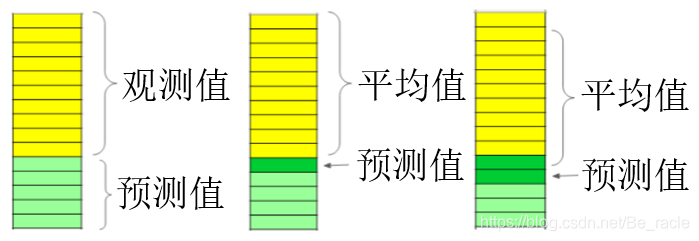

这种计算方法确保只对当前信息进行核算。事实上，任何移动平均算法都会呈现一定的滞后性。它以滞后性的代价换来了平滑性，移动平均必须在平滑性和滞后性之间取舍。

### 实验一 利用 MA 预测股票走势
#### 加载数据集

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# setting figure size 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10 

# for normalizing data 数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


可以看到数据集中有多个变量：日期，开盘价，最高价，最低价，最后一笔，收盘价，总交易量和营业额。

Open和Close代表该股票在某一天的交易开始和最终的价格。
High，Low和Last代表当天股票的最高价，最低价和最后价。
总交易量（Total Trade Quantity）是当天购买或出售的股票数量，而Turnover是公司在当天的营业额。
需要注意的是周末和公共假期市场休市。在上表中，缺少某些日期值，如2018-10-02（国定假日），2018-10-06（周末），2018-10-07（周末）。

损益计算通常由当天股票的收盘价决定，因此我们将收盘价视为目标变量。


In [7]:
# 查看数据格式
print(df.dtypes)
print('------')
print(df.index.dtype)

Date                     object
Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity    float64
Turnover (Lacs)         float64
dtype: object
------
int64


In [8]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']
print(df.dtypes)
print('-----')
print(df.index.dtype)

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity           float64
Turnover (Lacs)                float64
dtype: object
-----
datetime64[ns]


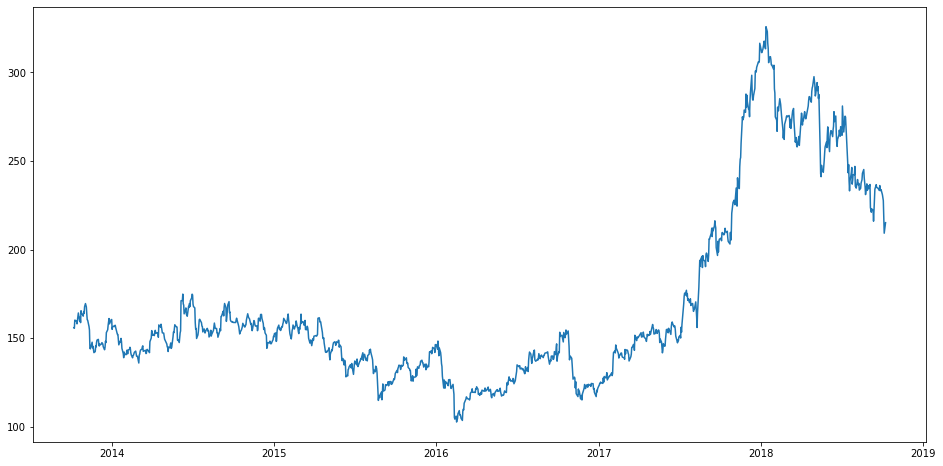

In [10]:
# 设置图形比例
plt.figure(figsize=(16,8))
# 查看原始数据的时间序列趋势图
plt.plot(df['Close'],label='Close Price History')

### 创建一个数据集，并分为『训练集』和『测试集』用于MA预测

为了不破坏原数据集, 重新定义一个DataFrame

In [22]:
# 对索引进行排序，并保存到data变量中， 默认就是对行(axis=0)进行升序ascending=True
data = df.sort_index(ascending=True, axis=0)

# 创建一个空的DataFrame 指定列名和索引 
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

# 赋值， 这个方法太麻烦了，用下面的简洁方法更合适
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
new_data

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45
...,...,...
1230,2018-10-01 00:00:00,230.9
1231,2018-10-03 00:00:00,227.6
1232,2018-10-04 00:00:00,218.2
1233,2018-10-05 00:00:00,209.2


In [23]:
# 从已有的DataFrame 创建一个新的DataFrame 更简洁
new_data2 = data[['Date','Close']]
new_data2

,Date,Close
Date,,
2013-10-08,2013-10-08,155.80
2013-10-09,2013-10-09,155.55
2013-10-10,2013-10-10,160.15
2013-10-11,2013-10-11,160.05
2013-10-14,2013-10-14,159.45
...,...,...
2018-10-01,2018-10-01,230.90
2018-10-03,2018-10-03,227.60
2018-10-04,2018-10-04,218.20


In [12]:
# 将数据分为『训练集』和『测试集』 比例一般为7：3， 或者8:2就差不多
train = new_data[:987]
valid = new_data[987:]

print('Shape of training set:')
print(train.shape)
print('Shape of validation set:')
print(valid.shape)


Shape of training set:
(987, 2)
Shape of validation set:
(248, 2)


测试集为248, 验证的时候 那么最好有>= 248个预测值， 这里采用移动平均方法， 就设置移动窗口为248，那么从训练集开始预测的第一个值的位置应该是 987 - 248 即原数据的第739个数开始进行求和平均

In [13]:
preds = [] # 移动平均求出的预测集
for i in range(0, valid.shape[0]):
    # 从739开始往后做移动平均
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248 # 移动窗口设置为248 
    preds.append(b)

通过均方根误差（RMSE，Root Mean Square Error）看一下效果。
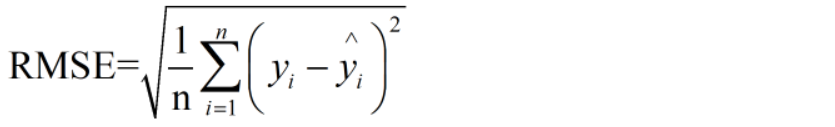

In [14]:
# checking the results (RMSE value) 
# 比如RMSE=10，可以认为回归效果相比真实值平均相差10
rms = np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('RMSE value on validation set:')
print(rms)

RMSE value on validation set:
104.51415465984348


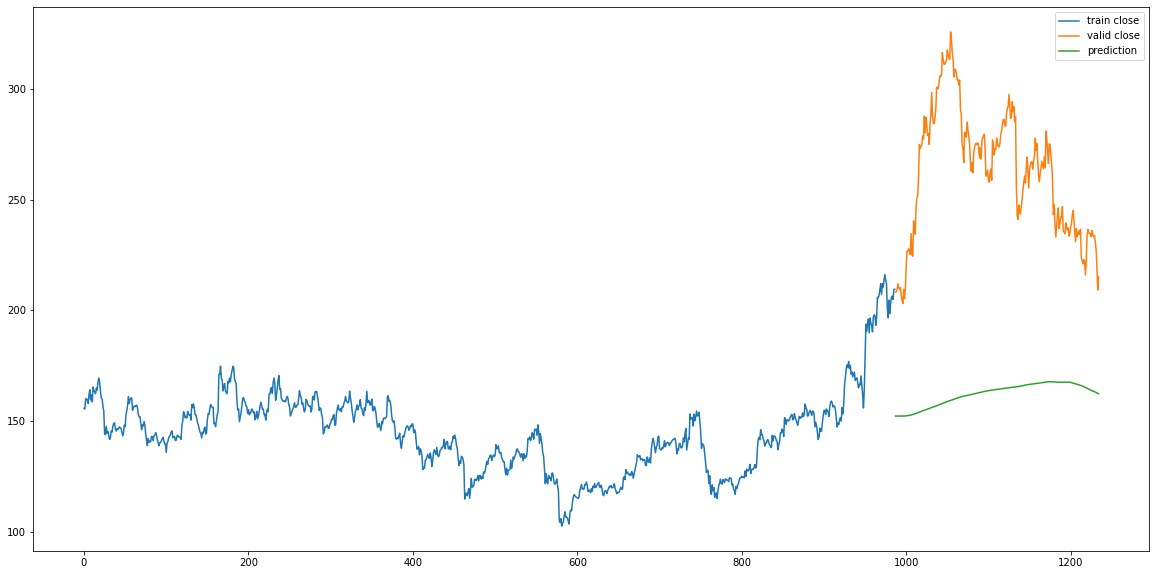

In [20]:
# 可以通过图直观显示预测效果，效果并不太理想
# 向valid 中新增一列 Predictions ,
# 需要先执行valid = valid.copy() 在赋值，这样就不会报错了
valid = valid.copy()
valid['Predictions'] = preds 
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(labels=('train close','valid close','prediction'))

In [24]:
test_data = {'Name':['Tom','Jack','Mike'], 'Age':[18,11,21]}
test_age = pd.DataFrame(test_data)
test_age

,Name,Age
0,Tom,18
1,Jack,11
2,Mike,21


In [25]:
test_age1 = test_age[['Age']]
test_age1

,Age
0,18
1,11
2,21


In [29]:
# 这里的行列值，原来是数字类型，那么这里也是数字类型，否则会导致新增一个数据记录
test_age1.loc[0,'Age']=180
test_age1

,Age
0,180.0
1,11.0
2,21.0
0,180.0


In [28]:
test_age

,Name,Age
0,Tom,18
1,Jack,11
2,Mike,21
